In [57]:
import cv2
import numpy as np

def crop_image(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        cropped_img = img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
    return img


def circle_crop(img):
    cropped_img = crop_image(img)

    height, width, depth = cropped_img.shape
    largest_side = np.max((height, width))
    resized_img = cv2.resize(cropped_img, (largest_side, largest_side))

    height, width, depth = resized_img.shape

    x = width // 2
    y = height // 2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(resized_img, resized_img, mask=circle_img)
    img = crop_image(img)

    return img


def crop_and_resize(image_path, target_size=(250, 250)):
    image = cv2.imread(image_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    average_pixel_value = np.mean(gray_image)
    if average_pixel_value < 5:
        image = cv2.resize(image, target_size)
        cv2.imwrite(image_path, image)
        return

    image = circle_crop(image)

    # Agregar un margen de 4 píxeles a la imagen
    border_color = [0, 0, 0]  # Color negro para el borde
    image = cv2.copyMakeBorder(image, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=border_color)

    image = cv2.resize(image, target_size)
    cv2.imwrite(image_path, image)

In [58]:
import os
import random
import csv
import shutil
from scipy.signal import wiener

def get_full_image_path(main_dir, img_name):
    for dirpath, dirnames, filenames in os.walk(main_dir):
        if img_name in filenames:
            return os.path.join(dirpath, img_name)
    return None

out_dir = os.getcwd() # running on the current folder
img_dir = img_dir = r'C:\Users\valen\OneDrive\Escritorio\Universidad\Procesamiento_digital_de_Imagenes\Proyecto Final\colored_images\colored_images'
label_csv = r'C:\Users\valen\OneDrive\Escritorio\Universidad\Procesamiento_digital_de_Imagenes\Proyecto Final\trainLabels.csv'
train_dir = os.path.join(out_dir, 'train')
valid_dir = os.path.join(out_dir, 'tmp_valid')
test_dir = os.path.join(out_dir, 'tmp_test')

if os.path.isdir(train_dir):
    shutil.rmtree(train_dir)
if os.path.isdir(valid_dir):
    shutil.rmtree(valid_dir)
if os.path.isdir(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(valid_dir)
os.makedirs(test_dir)
labels = ['label0', 'label1', 'label2', 'label3', 'label4']

for label in labels:
    os.makedirs(os.path.join(train_dir, label))
    os.makedirs(os.path.join(valid_dir, label))
    os.makedirs(os.path.join(test_dir, label))

# open csv file and read to dict img - label
img_labels = {}
with open(label_csv, 'r') as f:
    reader = csv.reader(f)
    next(reader) # skip header row
    for row in reader:
        img_name = row[0] + '.png'
        label = int(row[1])
        img_labels[img_name] = label

# randomly select one fifth of the images and write their rows to a new CSV file
img_number = int(len(list(img_labels.keys()))/50) # change to /3, /2 or /1 for bigger dataset 

selected_imgs = random.sample(list(img_labels.keys()), img_number)
random.shuffle(selected_imgs)
print(selected_imgs[0])

# split the selected imgs to train, test and validation
train_ratio = 0.7 
valid_ratio = 0.2 
test_ratio = 0.1

train_split = int(len(selected_imgs) * train_ratio)
valid_split = int(len(selected_imgs) * valid_ratio)

train_imgs = selected_imgs[:train_split]
valid_imgs = selected_imgs[train_split:train_split+valid_split]
test_imgs = selected_imgs[train_split+valid_split:]

for img_name in train_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(train_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)

for img_name in valid_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(valid_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)

for img_name in test_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(test_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)


12490_right.png


In [59]:
from scipy.signal import wiener

def enhance_contrast(image): 
    image = np.uint8(image)
    # Split the image into RGB channels
    red_channel, green_channel, blue_channel = cv2.split(image)
    # Apply CLAHE to the green channel only
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    green_channel = wiener(green_channel, 2, 0.01) # weiner filter
    green_enhanced = clahe.apply(np.uint8(green_channel))
    red_enhanced = clahe.apply(np.uint8(red_channel))
    blue_enhanced = clahe.apply(np.uint8(blue_channel))
    # Merge the enhanced green channel with the original red and blue channels
    enhanced_image = cv2.merge([red_channel, green_enhanced, blue_channel])
    # enhanced_image = cv2.blur(image, (4, 4)) # median filter
    return enhanced_image


def preprocess_image(img):
    img = enhance_contrast(img)
    return img

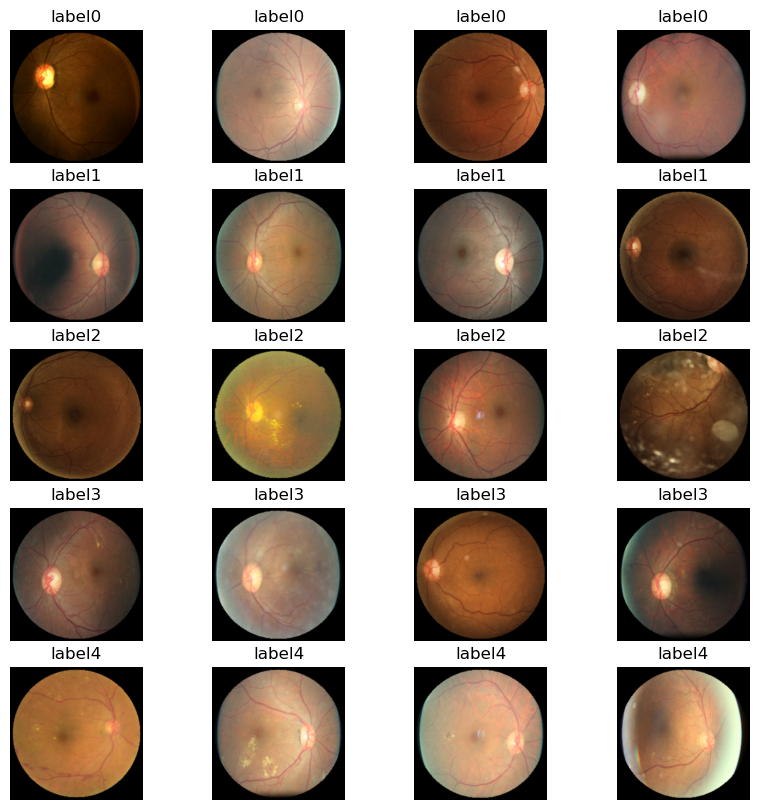

In [60]:
import os
import matplotlib.pyplot as plt
dir = train_dir
images = []
num = 4
for label in labels:
    img_dir = os.path.join(dir, label)
    image_paths = os.listdir(img_dir)
    image_paths = list(map(lambda img: os.path.join(img_dir, img), image_paths))
    images.extend(random.sample(image_paths, num))
plt.figure(figsize=(10, 10))
for i in range(5 * num):
    image = plt.imread(images[i])
   # image = preprocess_image(image)
    ax = plt.subplot(5, num, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(labels[int(i/num)])
    plt.axis("off")

In [61]:
# apply augmentation and CLAHE on training set -> move to augmentation set
import os
import pandas as pd
import cv2 as cv
import shutil
from scipy.signal import wiener


labels = ['label0', 'label1', 'label2', 'label3', 'label4']
# Specify the paths to the train folder and the augmented output folder
train_dir = 'train'
aug_dir = 'aug'

if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)

os.makedirs(aug_dir)

for label in labels:
    os.makedirs(os.path.join(aug_dir, label))
    
# create data frame
train_paths = []
label_image = []
for label in labels:
    for image_path in [os.path.join(train_dir, label, image) for image in os.listdir(os.path.join(train_dir, label))]:
        train_paths.append(image_path)
        label_image.append(label)
        
Fseries=pd.Series(train_paths, name='filepaths')
Lseries=pd.Series(label_image, name='labels')
train_df = pd.concat([Fseries, Lseries], axis = 1)

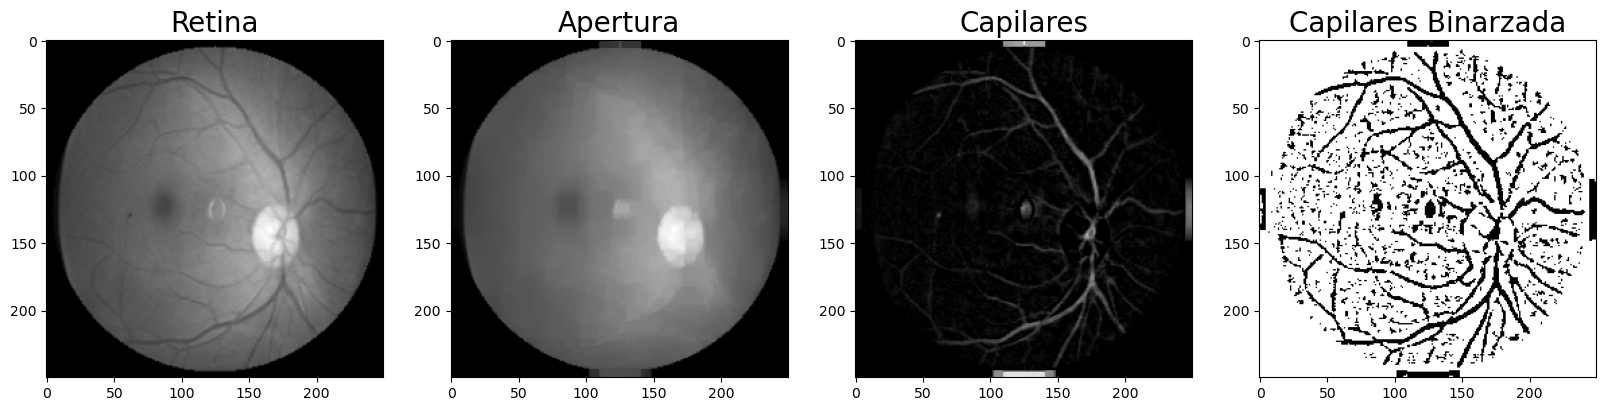

In [62]:
array = train_df[train_df['labels']=='label0'].values

img_path = array[2][0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

iteracion = 5

kernel = np.ones((3,3),np.uint8)
erosion = cv.dilate(img,kernel,iterations = iteracion)

plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
plt.title("Retina",fontsize=20)
plt.imshow(img, cmap='gray')


apertura = cv.erode(erosion, kernel, iterations= iteracion)

plt.subplot(1,4,2)
plt.title("Apertura",fontsize=20)
plt.imshow(apertura, cmap='gray')

capilares = apertura - img 

plt.subplot(1,4,3)
plt.title("Capilares",fontsize=20)
plt.imshow(capilares, cmap='gray')

capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)

plt.subplot(1,4,4)
plt.title("Capilares Binarzada",fontsize=20)
plt.imshow(capilares_binarizada, cmap='gray')

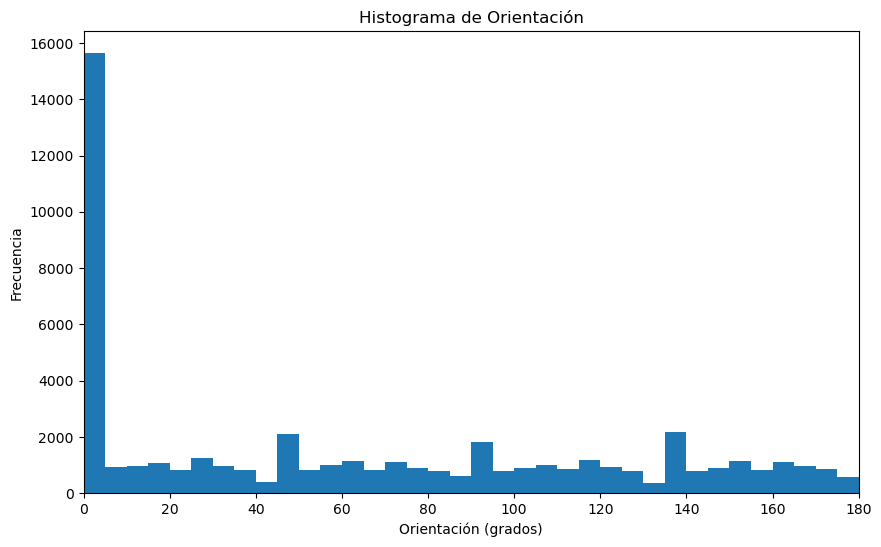

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen y convertirla a escala de grises

image =capilares

# Aplicar binarización adaptable
binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)

# Calcular el gradiente en las direcciones x e y
sobelx = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=5)

# Calcular la orientación del gradiente
orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180  # Convertir a grados y mantenerlo en [0, 180)

# Crear el histograma de orientación
hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
bin_centers = (bins[:-1] + bins[1:]) / 2

# Visualizar el histograma
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist, width=5)
plt.title('Histograma de Orientación')
plt.xlabel('Orientación (grados)')
plt.ylabel('Frecuencia')
plt.xlim([0, 180])
plt.show()


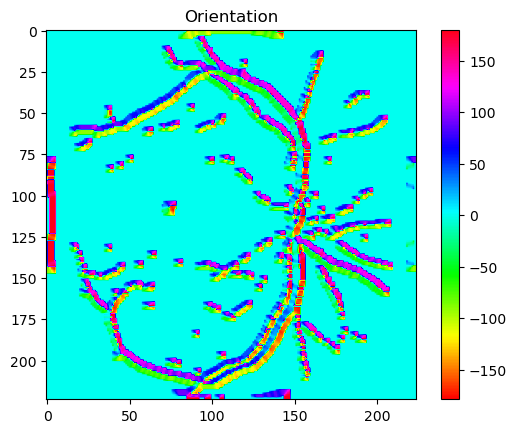

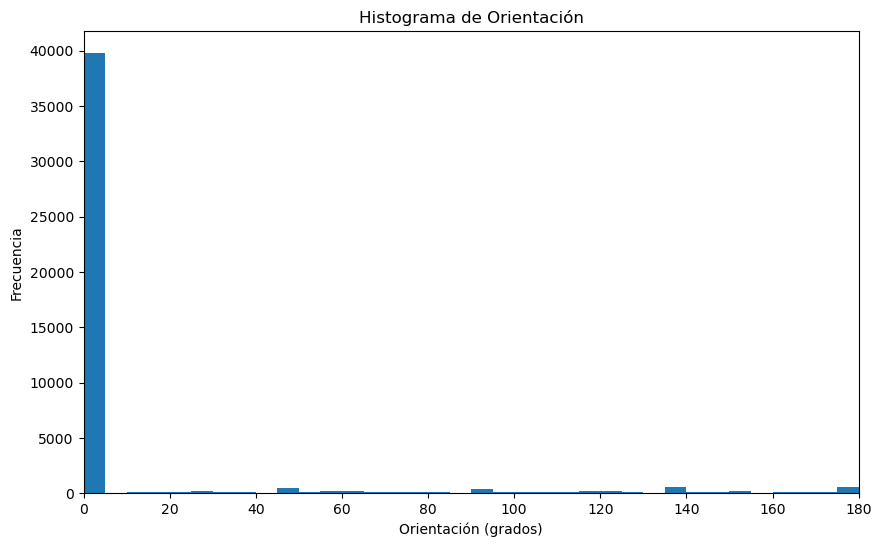

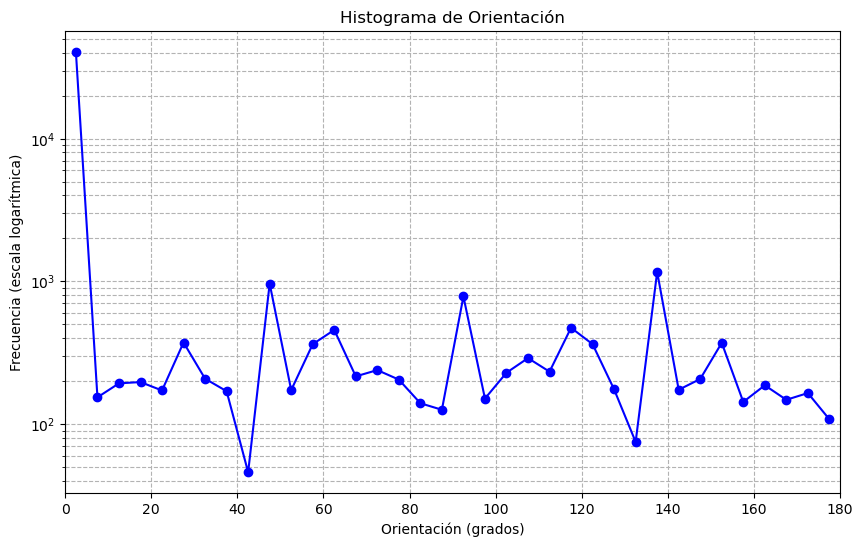

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen y convertirla a escala de grises
image = imagen_binarizada_negro

# Calcular el gradiente en las direcciones x e y
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

# Calcular la orientación del gradiente
orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180  # Convertir a grados y mantenerlo en [0, 180)

# Crear el histograma de orientación
hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
bin_centers = (bins[:-1] + bins[1:]) / 2

# Visualizar el histograma
plt.figure(figsize=(10, 6))
plt.semilogy(bin_centers, hist, 'b-o')
plt.title('Histograma de Orientación')
plt.xlabel('Orientación (grados)')
plt.ylabel('Frecuencia (escala logarítmica)')
plt.xlim([0, 180])
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()
